
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=493b3ded30c497b1966d51360f65927dc0c1b90ca14ceac6ad7e6e54c35acad7
  Stored in directory: /root/.cache/pip/wheels/aa/9c/60/f67813603a52fc35057868f1aba0003cc75b72583dcaa2c341
Successfully built sklearn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:
ha.info()
ha.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB


,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [ ]:
X = ha.drop(["cp"], axis=1)
y = ha["cp"]

In [ ]:

ct = ColumnTransformer(
    transformers=[
      ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
    ],
    remainder='passthrough'
)

knn1 = KNeighborsClassifier(n_neighbors=20)
knn_pipeline = Pipeline([
    ("preprocess", ct),
    ("knn", knn1)
])

degrees = {'knn__n_neighbors': np.arange(5,100)}
gscv = GridSearchCV(knn_pipeline, degrees, cv = 5, scoring='accuracy')
gscv_fitted = gscv.fit(X, y)
best_accuracy = pd.DataFrame(data = {"kNN_k": np.arange(5,100), "accuracy": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by='accuracy', ascending = False)
best_accuracy

,kNN_k,accuracy
15,20,0.549495
31,36,0.545926
14,19,0.542020
30,35,0.538586
16,21,0.538451
...,...,...
91,96,0.498249
1,6,0.494747
65,70,0.494680
64,69,0.494680


In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn_fit = knn.fit(X,y)

In [ ]:
dt1 = DecisionTreeClassifier(max_depth=20)
dt_pipeline = Pipeline([
    ("preprocess", ct),
    ("dt", dt1)
])

max_depth_values = np.arange(5, 20)

parameters = {'dt__max_depth': max_depth_values}
gscv = GridSearchCV(dt_pipeline, parameters, cv=5, scoring='accuracy')
gscv_fitted = gscv.fit(X, y)

best_max_depth = gscv_fitted.best_params_['dt__max_depth']
best_accuracy = gscv_fitted.best_score_

print("Best max_depth:", best_max_depth)
print("Best Accuracy:", best_accuracy)

Best max_depth: 5
Best Accuracy: 0.42855218855218863


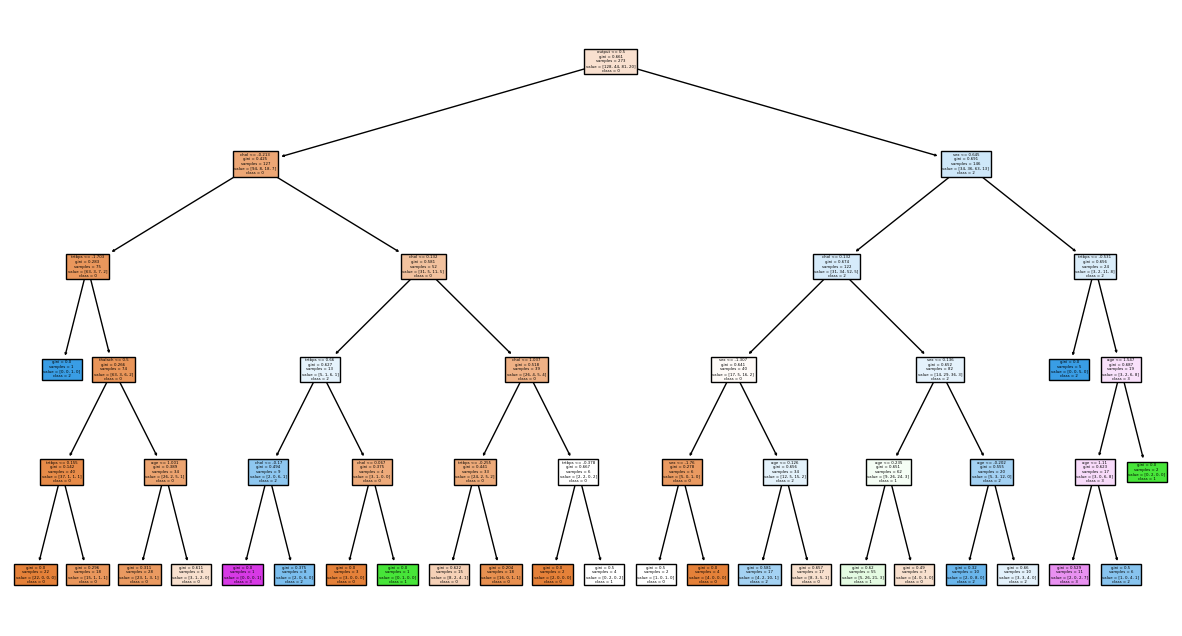

In [ ]:
best_dt_model = gscv_fitted.best_estimator_.named_steps['dt']
plt.figure(figsize=(15, 8))
plot_tree(best_dt_model, filled=True, feature_names=X.columns, class_names=np.unique(y).astype(str))
plt.show()

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, random_state=51)
dt_fit = dt.fit(X,y)

In [ ]:
lr = LogisticRegression()
lr_pipeline = Pipeline([
    ("preprocess", ct),
    ("lr", lr)
])


fitted_pipeline_lr = lr_pipeline.fit(X,y)

coef_names = ct.get_feature_names_out()
coef_with_names = zip(coef_names, fitted_pipeline_lr.named_steps['lr'].coef_[0])

for name, coef in coef_with_names:
    print(f"{name}: {coef}")



standardize__age: -0.08567252815920194
standardize__trtbps: -0.17990905647080868
standardize__chol: 0.09792887309538023
standardize__thalach: -0.5124064273157877
remainder__sex: -0.3108515123086861
remainder__restecg: -0.1088539238845045
remainder__output: -1.3743010274180056


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
ha['cp_is_3'] = ha['cp'].apply(lambda x: 1 if x == 3 else 0)

ct = ColumnTransformer(
    transformers=[
        ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
    ],
    remainder='passthrough'
)

lr_pipeline = Pipeline([
    ("preprocess", ct),
    ("lr", LogisticRegression())
])

X = ha.drop(["cp", "cp_is_3"], axis=1)
y = ha['cp_is_3']
f1 = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1_macro')
mean_f1 = np.mean(f1)
mean_f1



0.4799787225048261

In [ ]:
ha['cp_is_2'] = ha['cp'].apply(lambda x: 1 if x == 2 else 0)

X = ha.drop(["cp", "cp_is_2"], axis=1)
y = ha['cp_is_2']

f1 = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1_macro')
mean_f1 = np.mean(f1)
mean_f1

0.42857024184687065

In [ ]:
ha['cp_is_1'] = ha['cp'].apply(lambda x: 1 if x == 1 else 0)

X = ha.drop(["cp", "cp_is_1"], axis=1)
y = ha['cp_is_1']

f1 = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1_macro')
mean_f1 = np.mean(f1)
mean_f1

0.6700253974293005

In [ ]:
ha['cp_is_0'] = ha['cp'].apply(lambda x: 1 if x == 0 else 0)

X = ha.drop(["cp", "cp_is_0"], axis=1)
y = ha['cp_is_0']

f1 = cross_val_score(lr_pipeline, X, y, cv=5, scoring='f1_macro')
mean_f1 = np.mean(f1)
mean_f1

0.9629533262830586

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
ha.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      0 non-null      int64
 1   sex      0 non-null      int64
 2   cp       0 non-null      int64
 3   trtbps   0 non-null      int64
 4   chol     0 non-null      int64
 5   restecg  0 non-null      int64
 6   thalach  0 non-null      int64
 7   output   0 non-null      int64
 8   cp_is_3  0 non-null      int64
 9   cp_is_2  0 non-null      int64
 10  cp_is_1  0 non-null      int64
 11  cp_is_0  0 non-null      int64
dtypes: int64(12)
memory usage: 0.0 bytes


In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [ ]:
ha['cp'] = ha['cp'].apply(lambda x: 1 if x == 3 else 0 if x == 2 else x)

ha = ha[~ha['cp'].isin([2, 3])].copy()

X = ha.drop(["cp"], axis=1)
y = ha['cp']

roc_auc = cross_val_score(lr_pipeline, X, y, cv=5, scoring='roc_auc')
mean_roc_auc = np.mean(roc_auc)
mean_roc_auc

0.7062516751541142

In [ ]:
ha['cp'] = ha['cp'].apply(lambda x: 1 if x == 2 else 0 if x == 1 else x)

ha = ha[~ha['cp'].isin([1, 2])].copy()

X = ha.drop(["cp"], axis=1)
y = ha['cp']

roc_auc = cross_val_score(lr_pipeline, X, y, cv=5, scoring='roc_auc')
mean_roc_auc = np.mean(roc_auc)
mean_roc_auc

0.6444957983193277

In [ ]:
ha['cp'] = ha['cp'].apply(lambda x: 1 if x == 3 else 0 if x == 1 else x)

ha = ha[~ha['cp'].isin([1, 3])].copy()

X = ha.drop(["cp"], axis=1)
y = ha['cp']

roc_auc = cross_val_score(lr_pipeline, X, y, cv=5, scoring='roc_auc')
mean_roc_auc = np.mean(roc_auc)
mean_roc_auc

0.5979041028175976